# 웹 크롤링 & 데이터 분석

## 중앙선관위 데이터 분석하기

사이트 : http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09

모듈 설치 -> selenium

웹드라이버 -> 크롭웹드라이버.exe

구글 API Key

In [1]:
!pip install selenium

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [3]:
# 주피터 한글오류 해결

import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import font_manager, rc

# matplotlib를 통해 차트를 생성할 때 한글이 제대로 표시되지 않기 떄문에 OS에 따라 font 변경
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False


# 중앙선관위 역대선거

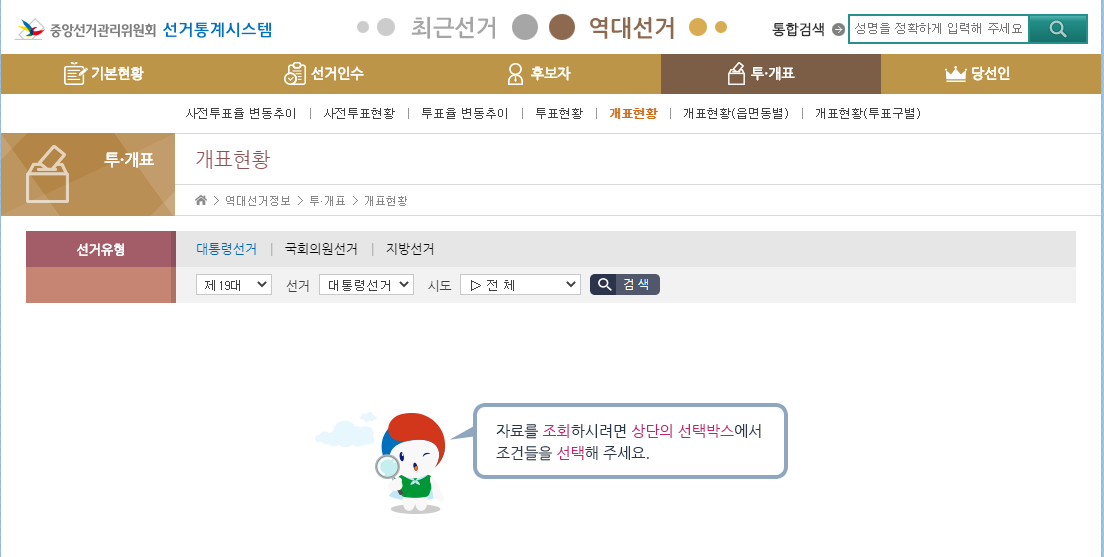

In [11]:
# 셀레니움을 이용하여 중앙선관위 역대선거 개표현황 페이지로 접속한다.

driver = webdriver.Chrome('chromedriver.exe')
driver.get("http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09")

In [12]:
# 대통령선거 항목 클릭

element = driver.find_element_by_xpath('''//*[@id="electionType1"]''')
element.send_keys(Keys.RETURN)
time.sleep(1)

In [13]:
# 제 몇대 선거인지를 선택

element = driver.find_element_by_xpath('''//*[@id="electionName"]''')
element.send_keys('제19대')
time.sleep(1)

In [14]:
# 다시 대통령선거를 선택

element = driver.find_element_by_xpath('''//*[@id="electionCode"]''')
element.send_keys('대통령선거')
time.sleep(1)

In [15]:
# HTML 분석을 위한 모듈 호출

from bs4 import BeautifulSoup

In [18]:
# 시군구와 전체 및 후보별 득표현황 데이터 저장

sido_name_list = []  # 시
sigun_name_list = [] # 군
pop = []             # 전체 개표현황 (전체 득표수)
moon = []            # 문재인 후보 득표현황
hong = []            # 홍준표 후보 득표현황
ahn = []             # 안철수 후보 득표현황

sido_name_values = ['서울특별시','부산광역시','대구광역시','인천광역시',
                    '광주광역시','대전광역시','울산광역시','세종특별자치시',
                    '경기도','강원도','충청북도','충청남도','전라북도',
                    '전라남도','경상북도','경상남도','제주특별자치도']

for sido_value in sido_name_values:
    element = driver.find_element_by_id('cityCode')
    element.send_keys(sido_value)
    time.sleep(1)
    
    element = driver.find_element_by_id('searchBtn')
    element.send_keys(Keys.RETURN)
      
    # 현재 페이지 소스정보를 가져온다.
    html = driver.page_source
    
    # HTML 분석
    soup = BeautifulSoup(html, 'html.parser')
    
    continue_count = 3
    count = 0
    
    # 페이지내의 표안에 표가 또 들어가는 경우가 있다.
    # tr 태그,   td 태그
    tr_all = soup.find('table', {'id':'table01'}).find_all('tr')
    
    for tr in tr_all:
        if count < continue_count:
            count += 1
            continue
        td_all = tr.find_all('td')
        column_pos = 0
        
        for td in td_all:
            # td 태그안에는 <br> 코드가 삽입되어 있으므로 제거해준다. 
            for br in td.find_all('br'):
                br.extract()
            
            # tr 태그의 내용 추출
            td_string = str(td)
            td_string = td_string.replace('</td>', '')
            pos = td_string.index('>')
            td_string = td_string[pos+1 : len(td_string)]
            
            if column_pos == 0:
                sido_name_list.append(sido_value)
                sigun_name_list.append(td_string)
                column_pos += 1
                continue
            
            if column_pos < 2:
                column_pos +=1
                continue
            
            if '(' in td_string:
                pos = td_string.index('(')
                td_string = td_string[:pos]
                
            # 득표현형을 float 형으로 바꾸기위해 쉼표(천단위기호)를 제거한다.
            if ',' in td_string:
                value = float(td_string.replace(',', ''))
            
            # 전체 득표현황 및 후보별 득표수 출력
            if column_pos == 2:
                pop.append(value)
                column_pos += 1
            
            elif column_pos == 3:
                moon.append(value)
                column_pos += 1
            
            elif column_pos == 4:
                hong.append(value)
                column_pos += 1
            
            elif column_pos == 5:
                ahn.append(value)
                column_pos += 1
            
            else:
                break
    time.sleep(1)

In [19]:
import re

In [20]:
election_result = pd.DataFrame({"광역시도": sido_name_list,
                               "시군": sigun_name_list,
                               "pop": pop,
                               "moon": moon,
                               "hong": hong,
                               "ahn": ahn})

election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [22]:
# 지도에 표시하기 위해 ID값 저장하기
election_result = pd.DataFrame({'광역시도':sido_name_list, 
                                '시군':sigun_name_list, 
                                'pop':pop, 
                                'moon':moon, 
                                'hong':hong, 
                                'ahn':ahn})

ID = []

for n in election_result.index:
    if (election_result['광역시도'][n][-1] == '시') & (election_result['광역시도'][n] != '세종특별자치시'):
        if len(election_result['시군'][n]) == 2:
            ID.append(election_result['광역시도'][n][:2] + ' ' + election_result['시군'][n])
        else:
            ID.append(election_result['광역시도'][n][:2] + ' ' + election_result['시군'][n][:-1])
            
    elif (election_result['광역시도'][n][-1] == '도'):
        tmp = election_result['시군'][n]
        
        if tmp[0] not in ['시','군']:
            tmp2 = re.split('시|군', tmp)
        else:
            tmp2 = [tmp[:-1], '']
        
        if len(tmp2[1]) == 2:
            tmp3 = tmp2[0] + ' ' + tmp2[1]
        elif len(tmp2[1]) >= 3:
            tmp3 = tmp2[0] + ' ' + tmp2[1][:-1]
        else:
            tmp3 = tmp2[0]
            
        ID.append(tmp3)
        
    else:
        ID.append('세종')

election_result['ID'] = ID

In [23]:
# 후보별 득표율을 구한다

election_result['rate_moon'] = election_result['moon']/election_result['pop']*100
election_result['rate_hong'] = election_result['hong']/election_result['pop']*100
election_result['rate_ahn'] = election_result['ahn']/election_result['pop']*100

In [24]:
# 지도에 표시항 좌표 활용하기

draw_korea = pd.read_csv('./0718/중앙선관위/05. draw_korea.csv', encoding='utf-8', index_col = 0)

In [25]:
# 전국 지명중에서 이름이 중복되는 곳은 정확하게 처리해야 한다.
# 예) 강원도 - 고성,   경상남도 - 고성
# 전국에서 동일지명을 각각 처리하고, 자치구에서 통폐합된 정보를 기준으로 재정렬한다.
# 이 부분은 1번만 실행해야 됨
# 두번 실행할 경우 오류가 발생할 수 있다.


election_result.loc[125, 'ID'] = '고성(강원)'
election_result.loc[233, 'ID'] = '고성(경남)'

election_result.loc[228, 'ID'] = '창원 합포'
election_result.loc[229, 'ID'] = '창원 회원'

ahn_tmp = election_result.loc[85, 'ahn']/3
hong_tmp = election_result.loc[85, 'hong']/3
moon_tmp = election_result.loc[85, 'moon']/3
pop_tmp = election_result.loc[85, 'pop']/3

rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

election_result.loc[250] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 소사', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 오정', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 원미', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

election_result.drop([85], inplace=True)


In [27]:
# ID 중복 제거

set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

set()

In [28]:
# 각 후보별 비교값 출력

final_elect_data = pd.merge(election_result, draw_korea, how='left', on=['ID'])

final_elect_data['moon_vs_hong'] = (final_elect_data['rate_moon'] - final_elect_data['rate_hong'])
final_elect_data['moon_vs_ahn'] = (final_elect_data['rate_moon'] - final_elect_data['rate_ahn'])
final_elect_data['ahn_vs_hong'] = (final_elect_data['rate_ahn'] - final_elect_data['rate_hong'])

In [29]:
# 지도 호출
   
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    vmin = -50
    vmax = 50

    BORDER_LINES = [
        [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
        [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
         (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
        [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
         (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
         (11,4), (11,3)], # 경기도
        [(8,10), (8,11), (6,11), (6,12)], # 강원도
        [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
         (15,4), (16,4), (16,2)], # 충청북도
        [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
         (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
        [(13,5), (13,6), (16,6)], # 대전시
        [(13,5), (14,5)], #세종시
        [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
        [(20,5), (21,5), (21,6), (23,6)], #전라남도
        [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
        [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
        [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
        [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
        [(16,11), (16,13)], #울산
    #     [(9,14), (9,15)], 
        [(27,5), (27,6), (25,6)],
    ]

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        if math.isnan(row['x']) or math.isnan(row['y']):
            print(row['ID'])
            continue

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()


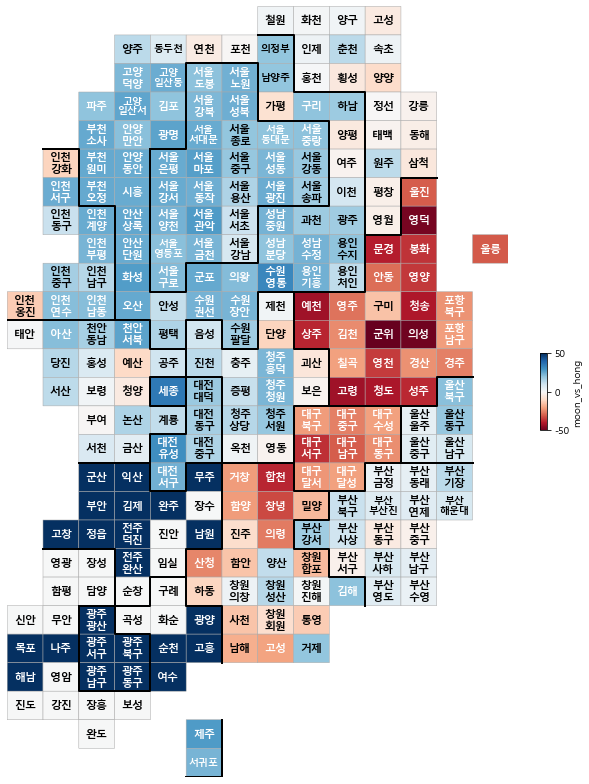

In [30]:
drawKorea('moon_vs_hong', final_elect_data, 'RdBu')

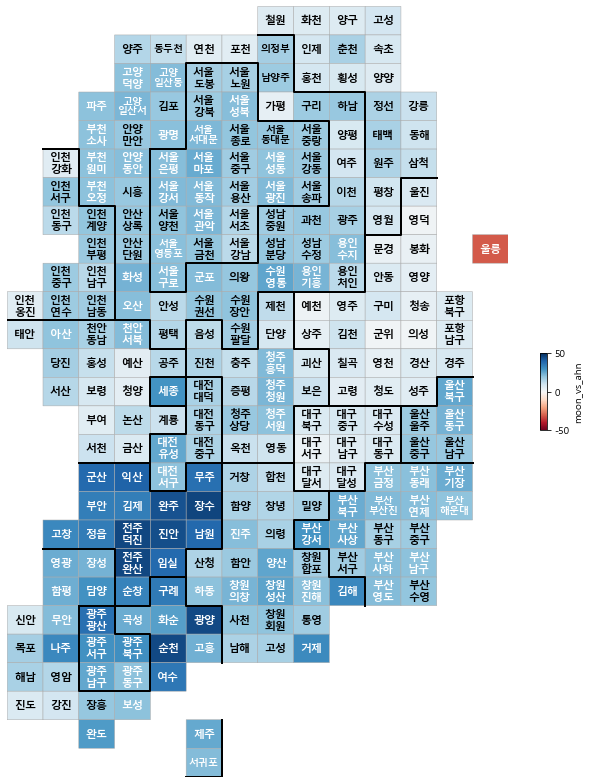

In [31]:
drawKorea('moon_vs_ahn', final_elect_data, 'RdBu')

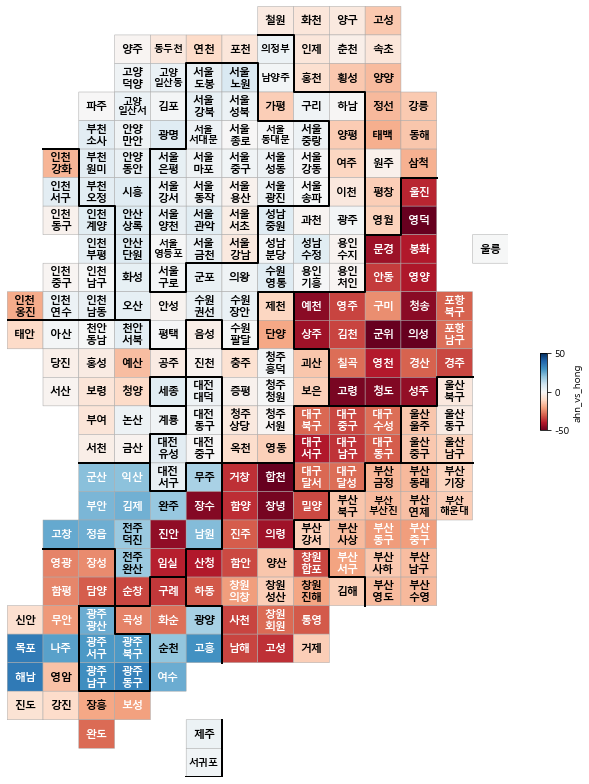

In [32]:
drawKorea('ahn_vs_hong', final_elect_data, 'RdBu')